In [1]:
### count plot of all the class labels. 
import os
import seaborn as sns
import tensorflow
import matplotlib.pyplot as plt
import nltk
from nltk.chunk import ne_chunk
from tqdm import tqdm
import codecs
import re
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
%load_ext tensorboard
import tensorflow_addons as tfa
import pydot
import graphviz

In [2]:
with open('processed_data.pickle','rb') as fe_data_file:
    final_data=pickle.load(fe_data_file)

In [3]:
raw_text=final_data[0]
email_data=final_data[1]
subject_data=final_data[2]
processed_text=final_data[3]
file_name=final_data[4]
class_details=final_data[5]

In [4]:
data=pd.DataFrame(list(zip(raw_text,email_data,subject_data,processed_text,file_name,class_details)),
             columns=['text','email_id','subject','processed_text','file_name','class'])
x=data['email_id']+data['subject']+ data['processed_text']
y=data['class']

In [5]:
total_class=list(data['class'].unique())
class_labels=dict()
for i in range(len(total_class)):
    class_labels[i]=total_class[i]
    y[y==total_class[i]]=i

In [6]:
y = np.asarray(y).astype(np.float32)

In [7]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25, stratify=y )
x_train.shape

(14121,)

In [8]:
#https://towardsdatascience.com/fix-pandas-parser-error-tokenizing-data-889167292d38
#Error related to importing a csv file in Pandas


In [9]:
import csv
trained_character_embedding=pd.read_csv('Character_Embedding.txt', sep=' ', header=None,lineterminator='\n',quoting=csv.QUOTE_NONE )

<pre>
<pre><img src="https://i.ytimg.com/vi/CNY8VjJt-iQ/maxresdefault.jpg" width="70%">
Here are the some papers based on Char-CNN
 1. Xiang Zhang, Junbo Zhao, Yann LeCun. <a href="http://arxiv.org/abs/1509.01626">Character-level Convolutional Networks for Text Classification</a>.NIPS 2015
 2. Yoon Kim, Yacine Jernite, David Sontag, Alexander M. Rush. <a href="https://arxiv.org/abs/1508.06615">Character-Aware Neural Language Models</a>. AAAI 2016
 3. Shaojie Bai, J. Zico Kolter, Vladlen Koltun. <a href="https://arxiv.org/pdf/1803.01271.pdf">An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling</a>
 4. Use the pratrained char embeddings <a href='https://github.com/minimaxir/char-embeddings/blob/master/glove.840B.300d-char.txt'>https://github.com/minimaxir/char-embeddings/blob/master/glove.840B.300d-char.txt</a>
</pre>

<img src='https://i.imgur.com/EuuoJtr.png'>

In [ ]:
#from tensorflow.keras.layers import Embedding

'''embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)'''
#https://towardsdatascience.com/how-to-preprocess-character-level-text-with-keras-349065121089
#https://keras.io/examples/nlp/pretrained_word_embeddings/

In [10]:
tokenizer=tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',char_level=True, oov_token='UNK')
tokenizer.fit_on_texts(x_train)

In [11]:
trained_character_embedding_chars=trained_character_embedding[0]
trained_character_embedding_vector=trained_character_embedding.drop(0,axis=1)

In [12]:
'''Step 1: To create a dictionary with index value: char value
Step 2: Create a matrix where index value has the vector value
Step 3: pre-trained word embeddings matrix'''

char_dict={}
embedding_matrix=np.zeros((len(trained_character_embedding_chars)+1,trained_character_embedding_vector.shape[1]))

for i,chars in enumerate(trained_character_embedding_chars.tolist()):
    char_dict[chars.lower()]= i
    embedding_matrix[i]=trained_character_embedding_vector.iloc[i]

In [13]:
tokenizer.word_index=char_dict
tokenizer.word_index[tokenizer.oov_token] = max(char_dict.values()) + 1

In [14]:
#tokenizer.word_index
tokenizer.word_index

{'$': 0,
 '(': 1,
 ',': 2,
 '0': 3,
 '4': 4,
 '8': 5,
 '<': 6,
 '@': 7,
 'd': 16,
 'h': 17,
 'l': 18,
 'p': 19,
 't': 20,
 'x': 21,
 '\\': 14,
 '`': 15,
 '|': 22,
 '#': 23,
 "'": 24,
 '+': 25,
 '/': 26,
 '3': 27,
 '7': 28,
 ';': 29,
 '?': 30,
 'c': 39,
 'g': 40,
 'k': 41,
 'o': 42,
 's': 43,
 'w': 44,
 '[': 37,
 '_': 38,
 '{': 45,
 '"': 46,
 '&': 47,
 '*': 48,
 '.': 49,
 '2': 50,
 '6': 51,
 ':': 52,
 '>': 53,
 'b': 62,
 'f': 63,
 'j': 64,
 'n': 65,
 'r': 66,
 'v': 67,
 'z': 68,
 '^': 61,
 '~': 69,
 '!': 70,
 '%': 71,
 ')': 72,
 '-': 73,
 '1': 74,
 '5': 75,
 '9': 76,
 '=': 77,
 'a': 86,
 'e': 87,
 'i': 88,
 'm': 89,
 'q': 90,
 'u': 91,
 'y': 92,
 ']': 85,
 '}': 93,
 'UNK': 94}

In [15]:
x_train_tokenized=tokenizer.texts_to_sequences(x_train)
x_test_tokenized=tokenizer.texts_to_sequences(x_test)

In [16]:
len(tokenizer.word_index)+ 1

70

In [17]:
padded_x_train=tf.keras.preprocessing.sequence.pad_sequences(x_train_tokenized,maxlen=(len(tokenizer.word_index)+1), padding='pre')
padded_x_test=tf.keras.preprocessing.sequence.pad_sequences(x_test_tokenized,maxlen=(len(tokenizer.word_index)+1), padding='pre')

In [18]:
max_values_in_list=[]
for j in x_train_tokenized:
    value=max(j)
    max_values_in_list.append(value)
    
input_dim=max(max_values_in_list)
input_dim

94

In [19]:
input_shape=(padded_x_train.shape[1])#input is just of this dimension
inputs = tf.keras.Input(input_shape)
output=tf.keras.layers.Embedding(input_dim=input_dim+1, output_dim=300, input_length=(1, input_shape),embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),trainable=False)(inputs) #Input shape=(Batch_size, Size of input)
output= tf.keras.layers.Conv1D(20,3,strides=1,activation='relu',input_shape=output.shape)(output)
output= tf.keras.layers.Conv1D(40,5,strides=1,activation='relu',input_shape=output.shape)(output)
output=tf.keras.layers.MaxPool1D()(output)
output= tf.keras.layers.Conv1D(20,7,strides=1,activation='relu',input_shape=output.shape)(output)
output= tf.keras.layers.Conv1D(40,9,strides=1,activation='relu',input_shape=output.shape)(output)
output=tf.keras.layers.MaxPool1D()(output)
output=tf.keras.layers.Flatten()(output)
output=tf.keras.layers.Dropout(0.2)(output)
output=tf.keras.layers.Dense(20, activation = 'softmax')(output)

model=tf.keras.Model(inputs=inputs,outputs=output)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 70)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 70, 300)           28500     
_________________________________________________________________
conv1d (Conv1D)              (None, 68, 20)            18020     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 40)            4040      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 40)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 26, 20)            5620      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 18, 40)            7240  

In [20]:
early_stopping=tf.keras.callbacks.EarlyStopping(patience=3,monitor='accuracy',min_delta=0.0001)
tensorboard=tf.keras.callbacks.TensorBoard(log_dir='logs/model_2')

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy',tfa.metrics.F1Score(num_classes=20, 
                      average='micro',
                      threshold=0.5)], )
model.fit(padded_x_train,y_train,epochs=200, callbacks=[early_stopping,tensorboard])

Epoch 1/200
442/442 [==============================] - 11s 19ms/step - loss: 2.9907 - accuracy: 0.0527 - f1_score: 4.1900e-05
Epoch 2/200
442/442 [==============================] - 8s 18ms/step - loss: 2.9858 - accuracy: 0.0586 - f1_score: 4.4185e-05
Epoch 3/200
442/442 [==============================] - 8s 18ms/step - loss: 2.9831 - accuracy: 0.0568 - f1_score: 2.8187e-05
Epoch 4/200
442/442 [==============================] - 8s 19ms/step - loss: 2.9727 - accuracy: 0.0636 - f1_score: 1.9502e-04
Epoch 5/200
442/442 [==============================] - 7s 16ms/step - loss: 2.9607 - accuracy: 0.0654 - f1_score: 4.8145e-04
Epoch 6/200
442/442 [==============================] - 7s 16ms/step - loss: 2.9493 - accuracy: 0.0724 - f1_score: 9.0422e-04
Epoch 7/200
442/442 [==============================] - 7s 17ms/step - loss: 2.9244 - accuracy: 0.1017 - f1_score: 0.0011
Epoch 8/200
442/442 [==============================] - 9s 19ms/step - loss: 2.8655 - accuracy: 0.1315 - f1_score: 0.0022
Epoch 9

In [32]:
model.save('models/model_2.h5')

In [2]:
model_2=tf.keras.models.load_model('models/model_2.h5')

In [22]:
model.evaluate(padded_x_test,y_test)

148/148 [==============================] - 1s 5ms/step - loss: 3.0301 - accuracy: 0.2061 - f1_score: 0.0170


[3.0301241874694824, 0.20607605576515198, 0.017029138281941414]

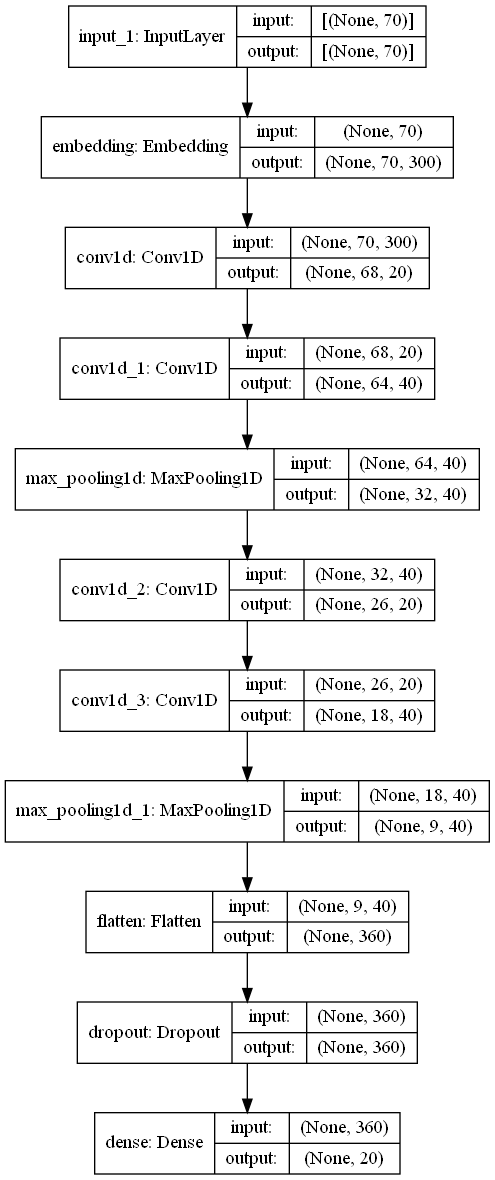

In [3]:
tf.keras.utils.plot_model(model_2, to_file='model_2.png', show_shapes=True)